## Training a Deep Neural Network for Wetland Vegetation Classification

**SR N.o - 22769**

In [1]:
from seaborn import heatmap
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sci_py
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torchview import draw_graph
data = sci_py.loadmat('gtspectra.mat')

## 1) Data Exploration

In [2]:
# This data is a dictionary where keys correspond to classes
print(data.keys())
print(len(data.keys()))

dict_keys(['Oak Hammock', 'Mud Flats', 'Spartina Marsh', 'Salt Marsh', 'Scrub', 'CP/Oak Hammock', 'CP Hammock', 'Typha Marsh', 'Willow Swamp', 'Hardwood Swamp', 'Graminoid Marsh', 'Slash Pine', 'Water Body'])
13


In [3]:
data['Graminoid Marsh'].T[290:310,:]

array([[15, 23, 14, ..., 12, 15,  8],
       [10, 23, 17, ...,  2,  9, 11],
       [10, 28, 20, ..., 17, 12,  2],
       ...,
       [12, 30, 19, ..., 17, 12, 11],
       [13, 28, 20, ..., 17, 15, 14],
       [10, 30, 20, ...,  9,  7, 17]], dtype=int16)

In [4]:
key_list = list(data.keys())
num_classes = len(key_list)
for i in range(num_classes):
    print(f'shape of {key_list[i]} = {data[key_list[i]].shape}')

shape of Oak Hammock = (176, 229)
shape of Mud Flats = (176, 503)
shape of Spartina Marsh = (176, 520)
shape of Salt Marsh = (176, 419)
shape of Scrub = (176, 761)
shape of CP/Oak Hammock = (176, 252)
shape of CP Hammock = (176, 256)
shape of Typha Marsh = (176, 404)
shape of Willow Swamp = (176, 243)
shape of Hardwood Swamp = (176, 105)
shape of Graminoid Marsh = (176, 431)
shape of Slash Pine = (176, 161)
shape of Water Body = (176, 927)


Explaination of the data
Example: Mud Flats
Reflectance measured across 176 bands of wavelengts. 503 samples of the 176 dim vector. After classification if there are 503 pixels that fall
under the category of 'Mud Flats', each pixel's bands(176) has been taken. This length instead of 176 would have been 3 for RGB, hence the name hyperspectral

1) Heatmap of the data given for individual class.
2) Plotting the first 10 samples from each class

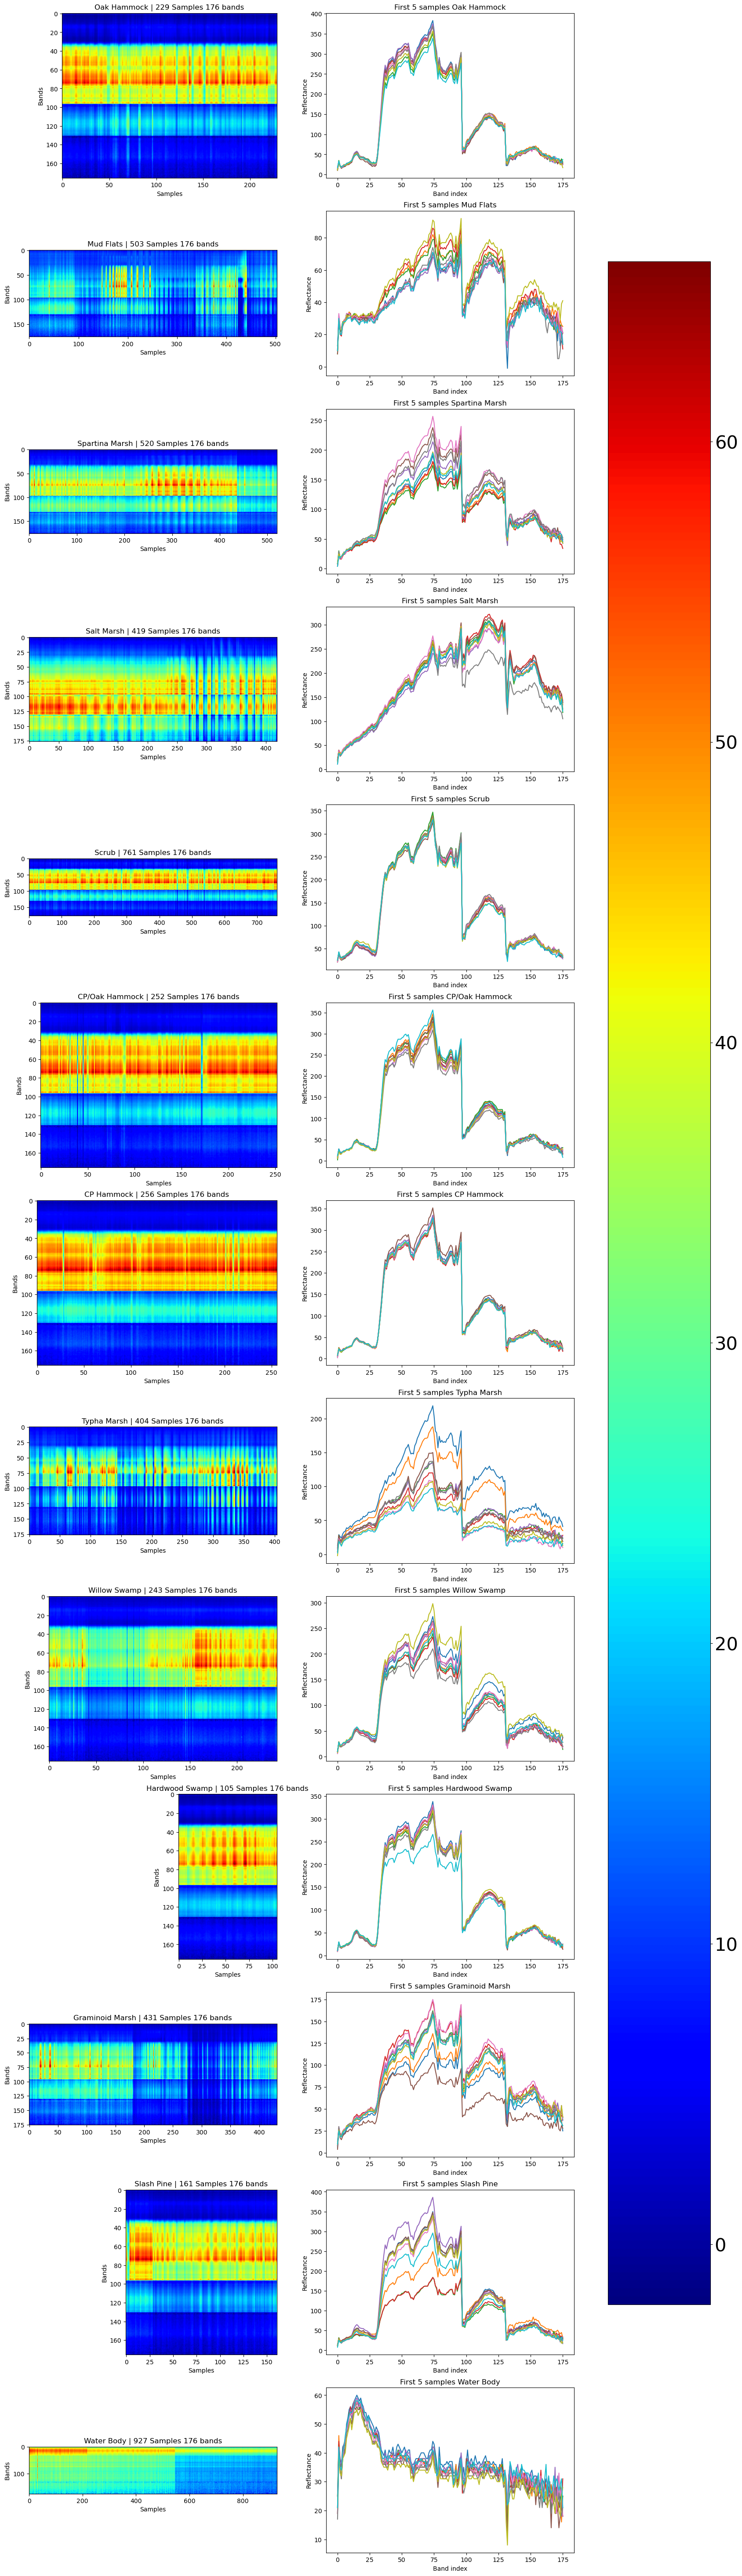

In [5]:
figs,axes = plt.subplots(nrows = num_classes,ncols = 2,figsize = (20,20)) # Plot heatmap(1st column) of the classes alo
plt.subplots_adjust(top=3)
for i in range(num_classes):
    # Heatmap of the bands vs sample matrix
    im = axes[i,0].imshow(data[key_list[i]], cmap = 'jet')
    axes[i,0].set_xlabel('Samples')
    axes[i,0].set_ylabel('Bands')
    shape = data[key_list[i]].shape
    axes[i,0].set_title(f'{key_list[i]} | {shape[1]} Samples {shape[0]} bands')
    # Plotting the first 10 samples: Reflectance vs band number
    for j in range(10): 
        axes[i,1].plot(data[key_list[i]][:,j])
        axes[i,1].set_xlabel('Band index')
        axes[i,1].set_ylabel('Reflectance')
        axes[i,1].set_title(f'First 5 samples {key_list[i]}')
cbar = plt.colorbar(im, ax=axes.ravel().tolist())
cbar.ax.tick_params(labelsize=30)
plt.show()

Through the heatmap and the plotting of the reflectance of the different samples, the following pattern can be observed

## 2) Data Preprocessing

To reshape and data suitable for classification we can:
1. Transpose of the individual class data to get (num_samples x 176) matrix, each row corresponds to a sample
2. Stack the data from all the classes such that it becomes ((num_samples(Oak Hammok) + num_samples(mud_flats) + ....) x 176) matrix
3. Make another matrix which will contain the target values [0, 1, 2...., 12]

In [6]:
n_samples = 0
for i in range(num_classes):
    shape = data[key_list[i]].shape
    n_samples = n_samples + shape[1]
print(f'Total num of samples adding all samples = {n_samples}')

Total num of samples adding all samples = 5211


In [7]:
Y_data = np.zeros((n_samples))
X_data = np.zeros((n_samples, 176))

In [8]:
n = 0 # will go to the end i.e 5211 - 1
for i in range(num_classes): # Iterating through all the classes
    data_ = data[key_list[i]].T # Taking transpose to make it (num_samples x 176), copy all the samples of each class
    shape = data_.shape
    for j in range(shape[0]): # Iterate through all the samples of a particular class
        Y_data[n] = i # Filling the target, as same as the index of each class, [the first 229 values will be 0, next 5
        X_data[n,:] = data_[j,:] # Stacking one over another
        n += 1

In [9]:
print(f'X_data : {X_data.shape} Y_data : {Y_data.shape}')

X_data : (5211, 176) Y_data : (5211,)


Text(0, 0.5, 'Frequency')

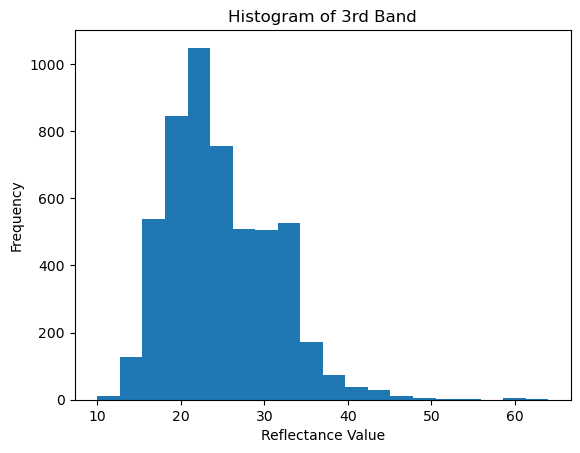

In [156]:
plt.hist(X_data[:,2],bins=20)
plt.title('Histogram of 3rd Band')
plt.xlabel('Reflectance Value')
plt.ylabel('Frequency')

In [11]:
a = np.array([[1,2],[3,4]])
from sklearn.preprocessing import MinMaxScaler, StandardScaler

MinMax = MinMaxScaler().fit_transform(a)
Standard = StandardScaler().fit_transform(a)

print(MinMax)
print(Standard)

[[0. 0.]
 [1. 1.]]
[[-1. -1.]
 [ 1.  1.]]


MinMaxScaler goes along the rows and calculates $x_{min}$ and $x_{max}$, then modifies the each feature $x_{new} = \frac{x - x_{min}}{x_{max} - x_{min}}$

StandardScaler goes along the rows and calculates $x_{mean}$ and $\sigma_x$, then modifies the each feature $x_{new} = \frac{x - x_{mean}}{\sigma_x}$

Plotting 176 histograms i.e for each of feature(band) across the entire set to find out its nature

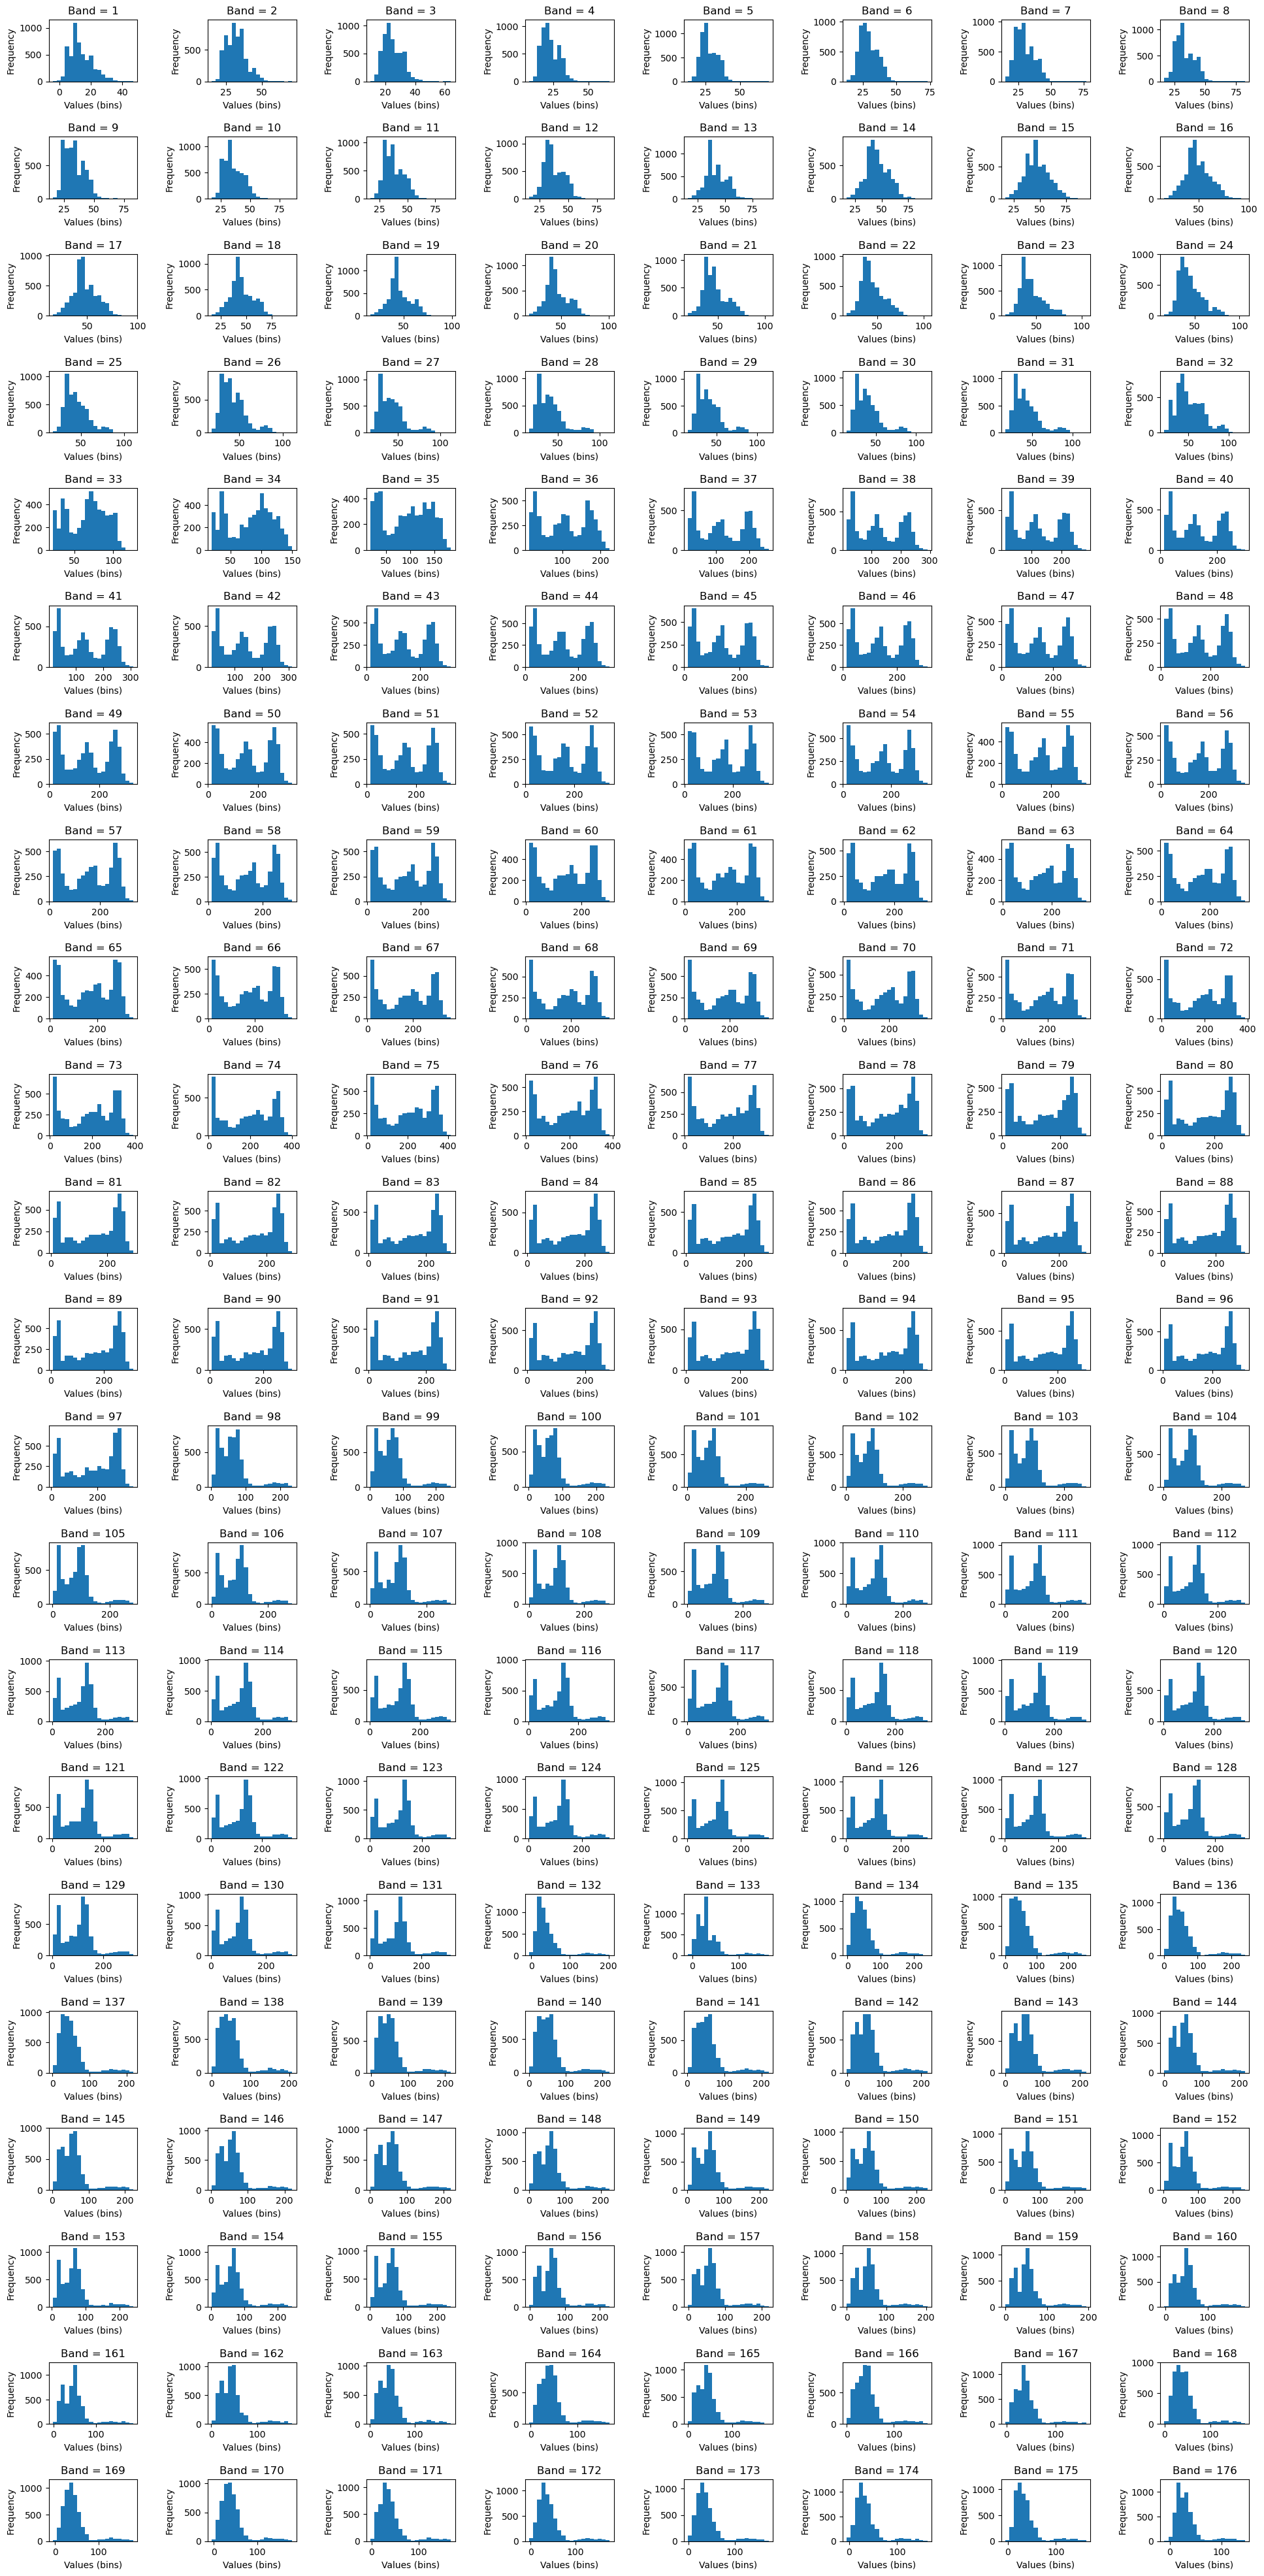

In [27]:
fig, axes = plt.subplots(176//8, 8, figsize = (20,40))
fig.tight_layout(pad=4.0)

i = 0 
j = 0
for band in range(176):
    i = int(band/8)
    j = band%8
    axes[i,j].hist(X_data[:,band], bins=20)
    axes[i,j].set_title(f'Band = {band+1}')
    axes[i,j].set_xlabel('Values (bins)')
    axes[i,j].set_ylabel('Frequency')
    
plt.show()

**All bands except for bands 33-131, have the shape of a normal distribution. Hence, it is justified in this case to use a StandardScaler rather than a MinMaxScaler.**

In [39]:
# Splitting the dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state = 42) # 80-20 train-test split


In [40]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Scaler_object = MinMaxScaler().fit(X_train) # Fit the normalizer object only on the training data

Scaler_object = StandardScaler().fit(X_train) # Fit the normalizer object only on the training data

X_train_n = Scaler_object.transform(X_train)
X_test_n = Scaler_object.transform(X_test)

MinMaxScaler was used previously but the accuracy was lower than StandardScaler, hence it is not used

In [30]:
# Checking if cuda is available to store the variables and model on GPU 
print(f'cuda Available? = {torch.cuda.is_available()}')
print(f'Current Device: {torch.cuda.current_device()}')
print(f'Name of Current Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
print(f'Memory Allocated: {torch.cuda.memory_allocated()}')
print(f'Cached memory allocated: {torch.cuda.memory_cached()}')

cuda Available? = True
Current Device: 0
Name of Current Device: NVIDIA GeForce RTX 3050 Laptop GPU
Memory Allocated: 0
Cached memory allocated: 0


C:\ProgramData\anaconda3\Lib\site-packages\torch\cuda\memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [41]:
# Convert data to PyTorch tensors and store in GPU , .cuda() extension is added
X_train = (torch.from_numpy(X_train_n).float()).cuda()
X_test = (torch.from_numpy(X_test_n).float()).cuda()
y_train = (torch.from_numpy(y_train).long()).cuda()
y_test = (torch.from_numpy(y_test).long()).cuda()

In [42]:
# Create data loaders
train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size= 32, shuffle=True)

## 3) Model Design

1) Seed is used such that the initial random weights that are alloted are same for each model initialization (Reproducibility).
2) Fully connected neural net is declared with ReLU as the activation function.
3) A schematic of the model is displayed using the torchview library.


(process:15412): Pango-WARNING **: 19:10:47.249: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


SpectrumClassifier(
  (linear1): Linear(in_features=176, out_features=96, bias=True)
  (linear2): Linear(in_features=96, out_features=48, bias=True)
  (linear3): Linear(in_features=48, out_features=13, bias=True)
)
True
True
True
True
True
True


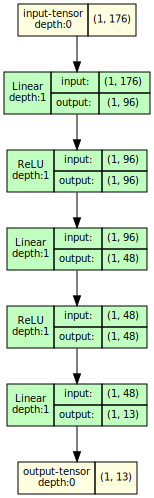

In [43]:

# Define the neural network

# Added for reproducibility, random state/seed corresponds to a particular initialization of weights
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_shape = 176
output_shape = 13

# 2 Hidden layers are added with relu activation function
class SpectrumClassifier(nn.Module):
    def __init__(self):
        super(SpectrumClassifier, self).__init__()
        self.linear1 = nn.Linear(input_shape, 96) 
        self.linear2 = nn.Linear(96, 48)
        self.linear3 = nn.Linear(48, output_shape)
    def forward(self, x):
        x = nn.ReLU()(self.linear1(x)) # 176 inputs each of 96 neurons: activation(linearly combined+bias)
        x = nn.ReLU()(self.linear2(x)) # torch.relu and nn.ReLU() works the same
        x = self.linear3(x) # Softmax is not required, we can work with just the raw outputs
        return x


# Instantiate the model, loss function, and optimizer
model = SpectrumClassifier().cuda()
criterion = nn.CrossEntropyLoss()


print(model)
for parameters in model.parameters():
    print(parameters.is_cuda) # Checking if the model parameters are stored in cpu


# Display the schematic of the model that has been initialized
model_graph = draw_graph(
    model, input_size=(1, 176),
    graph_name='SpectrumClassifier',
    roll=True
)
model_graph.visual_graph

## 4) Training the model

In [44]:
# Training loop

optimizer = optim.Adam(model.parameters(), lr=0.001) # Declaring the optimizer to be Adam and specifying the learning rate
num_epochs = 400

store_loss = np.zeros(num_epochs)
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    store_loss[epoch] = running_loss/len(train_loader)
    if((epoch+1)%10 == 0): #Print every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, ', end='||')

Epoch 10, Loss: 0.2083, ||Epoch 20, Loss: 0.1507, ||Epoch 30, Loss: 0.1138, ||Epoch 40, Loss: 0.0932, ||Epoch 50, Loss: 0.0727, ||Epoch 60, Loss: 0.0798, ||Epoch 70, Loss: 0.0502, ||Epoch 80, Loss: 0.0428, ||Epoch 90, Loss: 0.0381, ||Epoch 100, Loss: 0.0324, ||Epoch 110, Loss: 0.0309, ||Epoch 120, Loss: 0.0343, ||Epoch 130, Loss: 0.0293, ||Epoch 140, Loss: 0.0333, ||Epoch 150, Loss: 0.0137, ||Epoch 160, Loss: 0.0183, ||Epoch 170, Loss: 0.0267, ||Epoch 180, Loss: 0.0301, ||Epoch 190, Loss: 0.0595, ||Epoch 200, Loss: 0.0098, ||Epoch 210, Loss: 0.0220, ||Epoch 220, Loss: 0.0125, ||Epoch 230, Loss: 0.0365, ||Epoch 240, Loss: 0.0288, ||Epoch 250, Loss: 0.0014, ||Epoch 260, Loss: 0.0043, ||Epoch 270, Loss: 0.0012, ||Epoch 280, Loss: 0.0014, ||Epoch 290, Loss: 0.1340, ||Epoch 300, Loss: 0.0008, ||Epoch 310, Loss: 0.0009, ||Epoch 320, Loss: 0.0005, ||Epoch 330, Loss: 0.0008, ||Epoch 340, Loss: 0.0006, ||Epoch 350, Loss: 0.0009, ||Epoch 360, Loss: 0.0005, ||Epoch 370, Loss: 0.0011, ||Epoch 380,

In [45]:
# Training set accuracy
correct = 0
total = y_train.shape[0] # The num of rows is basically the total number of train samples

correct = 0
outputs = model(X_train)
_, predicted = torch.max(outputs.data, 1) # _ is a used since we don't actually need the values just the indices.
correct += (predicted == y_train).sum().item() # Correct will basically be number of times we get 'True' in (y_test == predicted)

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Accuracy: 100.00%


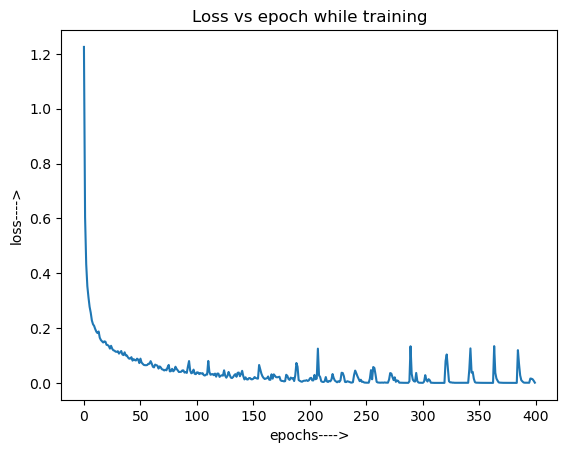

In [46]:
plt.plot(store_loss)
plt.xlabel('epochs---->')
plt.ylabel('loss---->')
plt.title('Loss vs epoch while training')
plt.show()

## 5) Evaluation of the model

Evaluating the model on the 20% data that was kept separately after train_test_split

$Accuracy = \frac{TruePositive + TrueNegative}{TruePositive+TrueNegative+FalsePositive+FalseNegative}$

Accuracy is defined for the entire training set across all the classes, but recall, precision and F1 score will be for individual class.

In [90]:
# Evaluation on the test set

# accuracy_total = (number of times the model predicted correctly / total number of samples)

correct = 0
total = y_test.shape[0] # The num of rows is basically the total number of test samples

correct = 0
outputs = model(X_test)
_, y_pred = torch.max(outputs.data, 1) # _ is a used since we don't actually need the values just the indices.
correct += (y_pred == y_test).sum().item() # Correct will basically be number of times we get 'True' in (y_test == predicted)

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 96.45%


In [91]:
# Function to calculate total number of trainable parameters
def num_trainable_params(m):
    sum = 0
    for i in m.parameters():
        if(i.requires_grad == True): # only count the parameters on which gradient is calculated
            sum += i.numel() # keep on adding the number of elements of the parameter array, layer by layer
    return sum

num_trainable_params(model)

22285

In [92]:
#Saving the model with a name which contains accuracy, n.o trainable parameters and epochs trained with.
name_model = f'Acc{int(100*correct/total)}_{num_trainable_params(model)}params_{num_epochs}epochs.torch'
print(f'Name of the model = {name_model}') 
torch.save(model, name_model) 

Name of the model = Acc96_22285params_400epochs.torch


Following is the calculation of class-wise **recall** for each of the 13 classes.

$Recall = \frac{TruePositive}{TruePositive+FalseNegative}$

Ref: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [93]:
# Testing out torch.where function the working of this function is given below

print(torch.where(y_test == 0)[0])   #this gives the index from the test set which contains the label for '0' class
print(torch.where(y_test == 0)[0].shape)

tensor([  18,   28,   52,   80,   85,  103,  114,  115,  143,  201,  211,  223,
         236,  242,  244,  249,  250,  301,  324,  355,  366,  393,  407,  491,
         506,  507,  586,  589,  591,  607,  613,  625,  635,  662,  668,  669,
         680,  682,  691,  694,  767,  774,  831,  856,  871,  888,  900,  918,
         929,  934,  939,  952, 1014, 1023, 1042], device='cuda:0')
torch.Size([55])


Recall can be thought of as (Number of times the class was predicted correctly / Total number of times the class was encountered)

In [82]:
# To find the class-wise recall of the model.
# Recall = TP/(TP + FN)

total_num_of_test_class = torch.zeros((num_classes))
correctly_predicted_elements_of_class = torch.zeros((num_classes))

for class_index in range(num_classes): # num_classes = 13, hence class_index = {0,1,2....,12} direct identifier of the class.S
    sum_correct = 0
    
    index_in_test_set = torch.where(y_test == class_index)[0]  # stores the index of test set where a particular class lies, 
                                                                # eg: '1' lies at [32, 122, 201]
    
    total_num_of_test_class[class_index] = (index_in_test_set.shape)[0]  # Stores the length of the array, 
                                                                        # eg: n.o of times '10' (Graminoid Marsh) appears in test set 
                                                                        # length of this is basically TP + FN
    
    for index in index_in_test_set:   # go through all the indices we found out for that particular class(index_in_test_set) variable
        if(y_pred[index] == class_index):  # This condtion will be satisfied for True Positives i.e whenever predicted = actual
            sum_correct += 1
    
    correctly_predicted_elements_of_class[class_index] = sum_correct # Copy number of times the model predicted correcly (TP)

print(f"Total elements array {total_num_of_test_class}")
print(f"Correctly predicted {correctly_predicted_elements_of_class}")

print(f'Total accuracy = {(correctly_predicted_elements_of_class.sum()/total_num_of_test_class.sum()).item()}') 
# To verify, this also for gives the accuracy

Total elements array tensor([ 55., 109., 105.,  93., 142.,  39.,  43.,  77.,  58.,  17.,  92.,  28.,
        185.])
Correctly predicted tensor([ 43., 108., 102.,  93., 141.,  36.,  40.,  76.,  53.,  17.,  87.,  25.,
        185.])
Total accuracy = 0.9645254015922546


In [83]:
recall_array_individual_class = 100 * correctly_predicted_elements_of_class/total_num_of_test_class
print(recall_array_individual_class)

tensor([ 78.1818,  99.0826,  97.1429, 100.0000,  99.2958,  92.3077,  93.0233,
         98.7013,  91.3793, 100.0000,  94.5652,  89.2857, 100.0000])


In [102]:
recall_array_individual_class = 100 * correctly_predicted_elements_of_class/total_num_of_test_class
print(recall_array_individual_class)


plt.figure(figsize=(30,5))
plt.bar(key_list, precision_array_individual_class)
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Test data Class-wise RECALL')
plt.show()

tensor([ 78.1818,  99.0826,  97.1429, 100.0000,  99.2958,  92.3077,  93.0233,
         98.7013,  91.3793, 100.0000,  94.5652,  89.2857, 100.0000])


Following is the calculation of class-wise **Precision** for each of the 13 classes.

$Precision = \frac{TruePositive}{TruePositive+FalsePositive}$

Ref: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [96]:
# To find the class-wise accuracy of the model.
# precision = (TP)/(TP + FP)

total_num_of_pred_class = torch.zeros((num_classes))
correctly_predicted_elements_of_class= torch.zeros((num_classes))

for class_index in range(num_classes): # num_classes = 13, hence class_index = {0,1,2....,12} direct identifier of the class.S
    sum_correct = 0


    # NOTE: This line makes the difference between Recall and Precison.
    # We are storing all the times our model has predicted this particular class i.e length of this array = TP + FP
    index_in_pred_set = torch.where(y_pred == class_index)[0]  # stores the index of prediction set where a particular 
                                                                #class lies, eg: '1' lies at [32, 122, 201]
    
    total_num_of_pred_class[class_index] = (index_in_pred_set.shape)[0]  # Stores the length of the array, 
                                                                        # eg: n.o of times '10' (Graminoid Marsh) appears in test set 
                                                                        # length of this will be TP + FP, since it deals with the predictions
    
    for index in index_in_pred_set:   # go through all the indices we found out for that particular class(index_in_test_set) variable
        if(y_test[index] == class_index):  # This condtion will be satisfied for (TP) i.e whenever predicted = actual
            sum_correct += 1
    
    correctly_predicted_elements_of_class[class_index] = sum_correct # Copy number of times the model predicted correcly for that class
                                                                    # Will store the TP for each class

print(f"Total elements in y_pred {total_num_of_pred_class}")
print(f"Correctly predicted {correctly_predicted_elements_of_class}")

print((correctly_predicted_elements_of_class.sum()/total_num_of_pred_class.sum()).item()) # To verify, this also for gives the accuracy

Total elements in y_pred tensor([ 46., 108., 106.,  94., 151.,  43.,  44.,  76.,  53.,  21.,  90.,  26.,
        185.])
Correctly predicted tensor([ 43., 108., 102.,  93., 141.,  36.,  40.,  76.,  53.,  17.,  87.,  25.,
        185.])
0.9645254015922546


In [97]:
total_num_of_pred_class.sum()

tensor(1043.)

tensor([ 78.1818,  99.0826,  97.1429, 100.0000,  99.2958,  92.3077,  93.0233,
         98.7013,  91.3793, 100.0000,  94.5652,  89.2857, 100.0000])


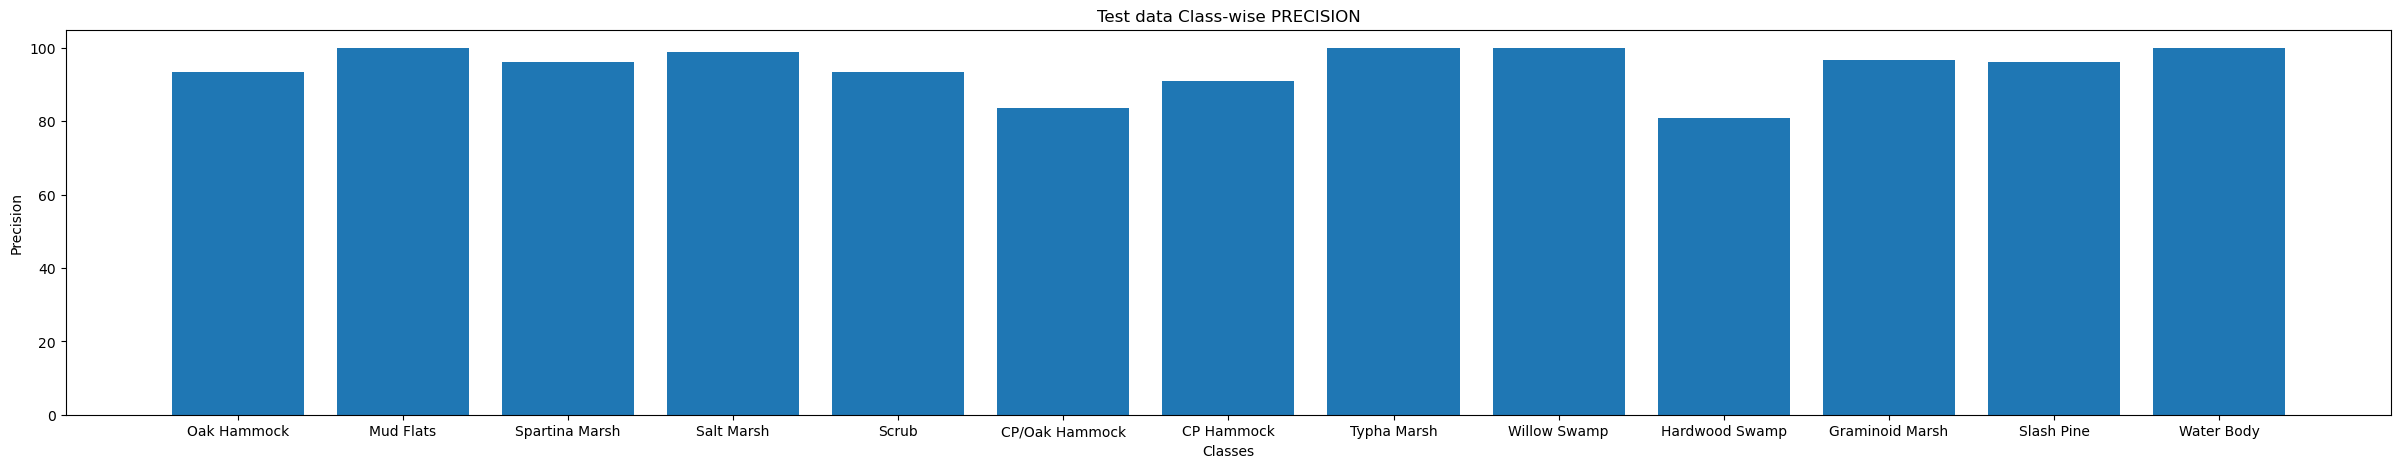

In [103]:
precision_array_individual_class = 100 * correctly_predicted_elements_of_class/total_num_of_pred_class
print(recall_array_individual_class)


plt.figure(figsize=(30,5))
plt.bar(key_list, precision_array_individual_class)
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Test data Class-wise PRECISION')
plt.show()

$F1 =2 * \frac{Precision*Recall}{Precision + Recall}$

Ref: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

tensor([ 85.1485,  99.5392,  96.6825,  99.4652,  96.2457,  87.8049,  91.9540,
         99.3464,  95.4955,  89.4737,  95.6044,  92.5926, 100.0000])


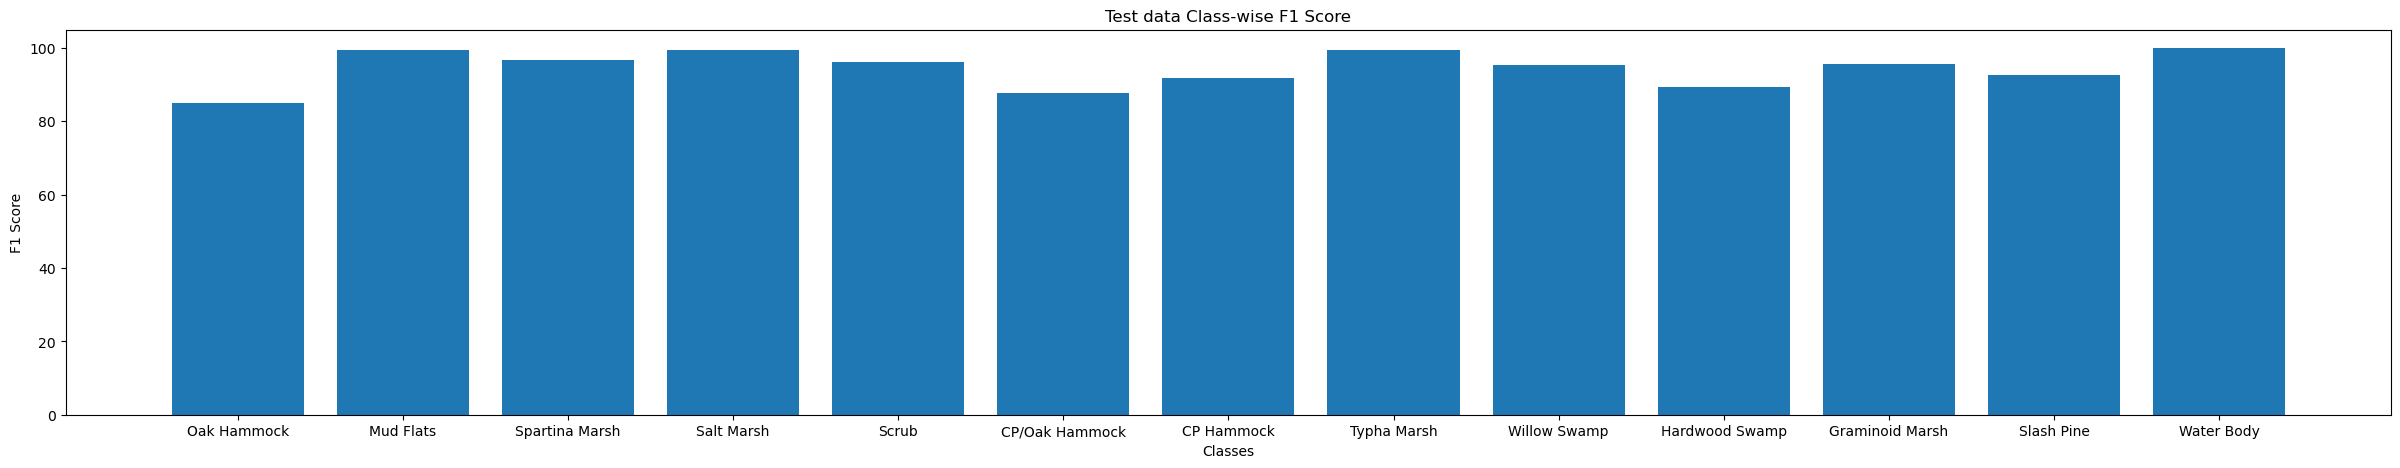

In [106]:
F1_score = 2 * (precision_array_individual_class * recall_array_individual_class)/(precision_array_individual_class + recall_array_individual_class)

print(F1_score)


plt.figure(figsize=(30,5))
plt.bar(key_list, F1_score)
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('Test data Class-wise F1 Score')
plt.show()

## 6) Multiple Hyper-parameter configurations

Hyper parameters that can be tuned are:
1) Number of hidden layers,
2) Number of neurons in each hidden layer,
3) Type of Activation Function
4) Type of optimizer
5) Learning rate
6) Batch size for training

2 Networks are declared, with 2 and 3 hidden layers. The number of neurons are parameterised so that it can be specified at the time of search.

In [114]:

# 2 Hidden layers are added with relu activation function
# We can now specify the number of neurons and the type of activation function by parameterizing it
class SpectrumClassifier_Depth_2(nn.Module):
    def __init__(self, neurons_Hidden, activation_func):
        super(SpectrumClassifier_Depth_2, self).__init__()
        self.neurons_H1 = neurons_Hidden[0]
        self.neurons_H2 = neurons_Hidden[1]
        self.activation_func = activation_func
        
        self.linear1 = nn.Linear(input_shape, self.neurons_H1) 
        self.linear2 = nn.Linear(self.neurons_H1, self.neurons_H2)
        self.linear3 = nn.Linear(self.neurons_H2, output_shape)
    def forward(self, x):
        x = self.activation_func(self.linear1(x)) # 176 inputs each of 64 neurons: activation(linearly combined+bias)
        x = self.activation_func(self.linear2(x))
        x = self.linear3(x) # Softmax is not required, we can work with just the raw outputs
        return x

# 3 Hidden layers added
class SpectrumClassifier_Depth_3(nn.Module):
    def __init__(self, neurons_Hidden, activation_func):
        super(SpectrumClassifier_Depth_3, self).__init__()
        self.neurons_H1 = neurons_Hidden[0]
        self.neurons_H2 = neurons_Hidden[1]
        self.neurons_H3 = neurons_Hidden[2]
        self.activation_func = activation_func
        
        self.linear1 = nn.Linear(input_shape, self.neurons_H1) 
        self.linear2 = nn.Linear(self.neurons_H1, self.neurons_H2)
        self.linear3 = nn.Linear(self.neurons_H2, self.neurons_H3)
        self.linear4 = nn.Linear(self.neurons_H3, output_shape)
    def forward(self, x):
        x = self.activation_func(self.linear1(x)) # 176 inputs each of 64 neurons: activation(linearly combined+bias)
        x = self.activation_func(self.linear2(x))   # torch.relu and nn.ReLU() functions the same
        x = self.activation_func(self.linear3(x))
        x = self.linear4(x) # Softmax is not required, we can work with just the raw outputs
        return x

# Defining a function that will give the model, training data loader and optimizer as output
# This will be useful for the search

def Make_NeuralNet(depth, neurons_Hidden, activation_func, batch_size, optimizer_type, learning_rate):

        # Define the neural network
    
    # Added for reproducibility, random state/seed corresponds to a particular initialization of weights
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
    
    if(depth == 2 and len(neurons_Hidden)==2):
        model = SpectrumClassifier_Depth_2(neurons_Hidden, activation_func).cuda() # Making an instance of depth = 3 NN
        optimizer = optimizer_type(model.parameters(), lr = learning_rate)

        return model, optimizer, train_loader

    elif(depth == 3 and len(neurons_Hidden)==3):
        model = SpectrumClassifier_Depth_3(neurons_Hidden, activation_func).cuda() # Making an instance of depth = 3 NN
        optimizer = optimizer_type(model.parameters(), lr = learning_rate)

        return model, optimizer, train_loader

    else:
        model = None
        optimizer = None
        print("Depth should be 2 or 3")
        return model, optimizer
        



Running a model to test this function


(process:20216): Pango-WARNING **: 21:59:12.376: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


SpectrumClassifier_Depth_3(
  (activation_func): LeakyReLU(negative_slope=0.01)
  (linear1): Linear(in_features=176, out_features=96, bias=True)
  (linear2): Linear(in_features=96, out_features=48, bias=True)
  (linear3): Linear(in_features=48, out_features=24, bias=True)
  (linear4): Linear(in_features=24, out_features=13, bias=True)
)
True
True
True
True
True
True
True
True


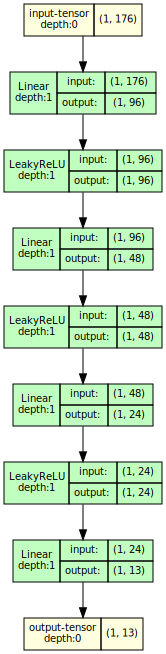

In [150]:
model_, optimizer_, train_loader_ = Make_NeuralNet(depth = 3, 
                                    neurons_Hidden=[96,48,24], 
                                    activation_func= nn.LeakyReLU(), 
                                    batch_size = 64, 
                                    optimizer_type=optim.AdamW, 
                                    learning_rate= 1e-3)


print(model_)
for parameters in model_.parameters():
    print(parameters.is_cuda) # Checking if the model parameters are stored in cpu

# Display the schematic of the model that has been initialized
model_graph = draw_graph(
    model_, input_size=(1, 176),
    graph_name='SpectrumClassifier',
    roll=True
)
model_graph.visual_graph

Epoch 10, Loss: 0.2445, ||Epoch 20, Loss: 0.1631, ||Epoch 30, Loss: 0.1200, ||Epoch 40, Loss: 0.1100, ||Epoch 50, Loss: 0.0771, ||Epoch 60, Loss: 0.0701, ||Epoch 70, Loss: 0.0636, ||Epoch 80, Loss: 0.0513, ||Epoch 90, Loss: 0.0488, ||Epoch 100, Loss: 0.0524, ||Epoch 110, Loss: 0.0353, ||Epoch 120, Loss: 0.0277, ||Epoch 130, Loss: 0.0554, ||Epoch 140, Loss: 0.0263, ||Epoch 150, Loss: 0.0295, ||Epoch 160, Loss: 0.0173, ||Epoch 170, Loss: 0.0206, ||Epoch 180, Loss: 0.0187, ||Epoch 190, Loss: 0.0268, ||Epoch 200, Loss: 0.0201, ||
Train Accuracy: 99.57%
Test Accuracy: 96.16%


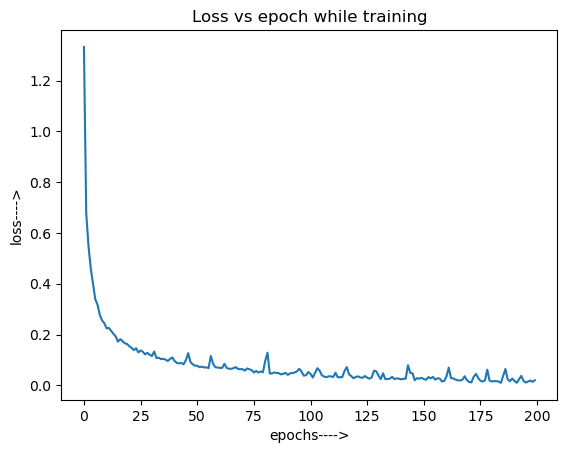

In [151]:
# Training loop


num_epochs = 200

store_loss = np.zeros(num_epochs)
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_.zero_grad()
        outputs = model_(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_.step()
        running_loss += loss.item()
    store_loss[epoch] = running_loss/len(train_loader)
    if((epoch+1)%10 ==0): #Print every 10 epochs
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, ', end='||')

print("")

# Training set accuracy
correct = 0
total = y_train.shape[0] # The num of rows is basically the total number of train samples

correct = 0
outputs = model_(X_train)
_, predicted = torch.max(outputs.data, 1) # _ is a used since we don't actually need the values just the indices.
correct += (predicted == y_train).sum().item() # Correct will basically be number of times we get 'True' in (y_test == predicted)

print(f'Train Accuracy: {100 * correct / total:.2f}%')


# Evaluation on the test set
correct = 0
total = y_test.shape[0] # The num of rows is basically the total number of test samples

correct = 0
outputs = model_(X_test)
_, predicted = torch.max(outputs.data, 1) # _ is a used since we don't actually need the values just the indices.
correct += (predicted == y_test).sum().item() # Correct will basically be number of times we get 'True' in (y_test == predicted)

print(f'Test Accuracy: {100 * correct / total:.2f}%')

plt.plot(store_loss)
plt.xlabel('epochs---->')
plt.ylabel('loss---->')
plt.title('Loss vs epoch while training')
plt.show()

In [137]:
# Configurations to search on

# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity || Reference
# activation_function_list = [nn.ReLU(), nn.LeakyReLU(), nn.Tanh(), nn.Sigmoid(), nn.ELU(), nn.GELU()]

activation_function_list = [nn.ReLU(), nn.LeakyReLU()]

# https://pytorch.org/docs/stable/optim.html || Reference
# https://towardsdatascience.com/why-adamw-matters-736223f31b5d
optimizer_list = [optim.Adam, optim.AdamW]

# hidden_neuron_list = [[120,60], [180, 90], [176, 88], [180, 90, 45], [176, 88, 44]]

hidden_neuron_list = [[160, 80], [160, 80, 40]]


batch_size_list = [16, 32, 64] # 3 values

print("Number of configurations",(len(activation_function_list) * len(optimizer_list) * len(hidden_neuron_list) * len(batch_size_list)))

Number of configurations 24


In [138]:
# Run loops through all the configurations, store the models, optimizers and, activations in list. 
store_models = []
store_optimizers = []
store_activations = []
store_batch = []
for batch_size in batch_size_list:
    for activation in activation_function_list:
        for optimizer in optimizer_list:
            for depth_index in range(len(depth_list)):
                model_, optimizer_, train_loader_ = Make_NeuralNet(depth = len(hidden_neuron_list[depth_index]), 
                                        neurons_Hidden= hidden_neuron_list[depth_index], 
                                        activation_func= activation, 
                                        batch_size = batch_size, 
                                        optimizer_type = optimizer, 
                                        learning_rate= 1e-3)

                print(model_, activation, batch_size, optimizer)
                
                # Store the hyper-parameters
                store_models.append(model_) 
                store_optimizers.append(optimizer_)
                store_activations.append(activation)
                store_batch.append(batch_size)

                # Training
                num_epochs = 200
                
                store_loss = np.zeros(num_epochs)
                for epoch in range(num_epochs):
                    running_loss = 0.0
                    for inputs, labels in train_loader:
                        optimizer_.zero_grad()
                        outputs = model_(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer_.step()
                        running_loss += loss.item()
                    store_loss[epoch] = running_loss/len(train_loader)
                    if((epoch+1)%40 ==0): #Print every 40 epochs
                        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, ', end='||')
                print("")



SpectrumClassifier_Depth_2(
  (activation_func): ReLU()
  (linear1): Linear(in_features=176, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=80, bias=True)
  (linear3): Linear(in_features=80, out_features=13, bias=True)
) ReLU() 16 <class 'torch.optim.adam.Adam'>
Epoch 40, Loss: 0.0764, ||Epoch 80, Loss: 0.0415, ||Epoch 120, Loss: 0.0220, ||Epoch 160, Loss: 0.0225, ||Epoch 200, Loss: 0.0042, ||
SpectrumClassifier_Depth_3(
  (activation_func): ReLU()
  (linear1): Linear(in_features=176, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=80, bias=True)
  (linear3): Linear(in_features=80, out_features=40, bias=True)
  (linear4): Linear(in_features=40, out_features=13, bias=True)
) ReLU() 16 <class 'torch.optim.adam.Adam'>
Epoch 40, Loss: 0.0981, ||Epoch 80, Loss: 0.0596, ||Epoch 120, Loss: 0.0277, ||Epoch 160, Loss: 0.0389, ||Epoch 200, Loss: 0.0090, ||
SpectrumClassifier_Depth_2(
  (activation_func): ReLU()
  (linear1): Linear(in

In [144]:
store_accuracy_test = []
for model in store_models:
    correct = 0
    total = y_test.shape[0] # The num of rows is basically the total number of test samples
    
    correct = 0
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1) # _ is a used since we don't actually need the values just the indices.
    correct += (predicted == y_test).sum().item() # Correct will basically be number of times we get 'True' in (y_test == predicted)

    store_accuracy_test.append(correct/total)
    #print(f'Test Accuracy: {100 * correct / total:.2f}%')
print(store_accuracy_test)


[0.962607861936721, 0.962607861936721, 0.9693192713326941, 0.9674017257909875, 0.9664429530201343, 0.9568552253116012, 0.9645254074784276, 0.9520613614573347, 0.9606903163950143, 0.9606903163950143, 0.9578139980824545, 0.9664429530201343, 0.962607861936721, 0.959731543624161, 0.9664429530201343, 0.965484180249281, 0.965484180249281, 0.959731543624161, 0.9587727708533078, 0.962607861936721, 0.962607861936721, 0.9683604985618408, 0.9587727708533078, 0.9712368168744008]
Highest Accuracy: 97.12368168744008


In [149]:
# Displaying Hyperparameter configuration corresponding to the highest accuracy
max_accuracy = max(store_accuracy_test)
print(f'Highest Accuracy: {max_accuracy*100}')
max_index = store_accuracy_test.index(max_accuracy)
print(store_models[max_index])
print(store_activations[max_index])
print(store_optimizers[max_index])
print(store_batch[max_index])

Highest Accuracy: 97.12368168744008
SpectrumClassifier_Depth_3(
  (activation_func): LeakyReLU(negative_slope=0.01)
  (linear1): Linear(in_features=176, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=80, bias=True)
  (linear3): Linear(in_features=80, out_features=40, bias=True)
  (linear4): Linear(in_features=40, out_features=13, bias=True)
)
LeakyReLU(negative_slope=0.01)
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)
64


For the current hyperparameter search we get the highest accuracy for the configuration:
1) Optimizer: AdamW
2) Activation: LeakyRelu
3) Hidden Layers = 3
4) Hidden Layer Configuration = [160, 80, 40]
5) Batch Size = 64

This is not an exhaustive search as it went through only 24 configurations. A more systematic search is when a function is written such as the inputs are hyperparameters and ouput is accuracy, optimization algorithm(eg Genetic Algorithm) trying to maximise this function by tweaking the hyperparameters.

This accuracy can be sensitive to train_test_split, random initialization of weights(to a lesser extent).

The reason for the this accuracy cannot be exactly pointed out as for every network but the following may be responsible:
1) More hidden layer depth and width resulting in more generalizing ability
2) The type of optimizer AdamW.(Ref: https://towardsdatascience.com/why-adamw-matters-736223f31b5d )
3) The batch size of 64 might have been a good tradeoff between SGD and full batch, just enough noisy to generalize better and reduce computation time.